In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from vasppy.calculation import import_calculations_from_file

from figure_formatting import figure_formatting as ff
ff.formatting['axes.linewidth'] = 0.5
ff.formatting['lines.linewidth'] = 1.0
ff.set_formatting()

In [2]:
colors = {'blue': '#264653',
          'bluegreen': '#287271',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [3]:
def bayesian_bootstrap(data, n_samples):
    rng = np.random.default_rng()
    return np.mean(data * rng.dirichlet(alpha=np.ones_like(data), size=n_samples)*len(data), axis=1)

In [4]:
def get_dict_entries(keys, full_dict):
    """
    Return entry in a dictionary with a given key.
    """
    return [full_dict[key] for key in keys][0]


def calculate_intercalation_energy(entry, li_energy, ref):
    """
    Calculate intercalation energy using the given entry and Li energy.
    """
    return entry.energy - ref - li_energy * entry.stoichiometry["Li"]


def get_reference_energy(calc_dict):
    """
    Get reference energy from the host structure in the set of all calculations.
    """
    entry = [entry for entry in calc_dict.values() if "Li" not in entry.stoichiometry.keys()][0]
    return entry.energy


# Load data
Li_dict = import_calculations_from_file("elemental_Li_vasp_summary.yaml")
ga_dict = import_calculations_from_file("vasp_summary_GA.yaml", skip_incomplete_records=True)
cis_dict = import_calculations_from_file("vasp_summary_cis.yaml")
sqs_dict = import_calculations_from_file("vasp_summary_sqs.yaml")

elemental_Li = get_dict_entries(["elemental Li opt"], Li_dict)
Li_energy = elemental_Li.energy / elemental_Li.stoichiometry["Li"]

# Calculate reference energies
cis_reference_energy = get_reference_energy(cis_dict)
sqs_reference_energy = get_reference_energy(sqs_dict)
ga_reference_energy = get_reference_energy(ga_dict)

# Calculate and print intercalation energies
records = []
for calc_dict, ref, label in zip([cis_dict, sqs_dict, ga_dict], [cis_reference_energy, sqs_reference_energy, ga_reference_energy], ["cis", "sqs", "ga"]):
    for key, entry in calc_dict.items():
        if entry.stoichiometry["Li"] == 0:
            continue
        intercalation_energy = calculate_intercalation_energy(entry, Li_energy, ref)
        row = dict(row=key, intercalation_energy=intercalation_energy, label=label)
        records.append(row)

df = pd.DataFrame.from_records(records)
df

,row,intercalation_energy,label
0,TiOF2-Li config 0 (cis),-1.410146,cis
1,TiOF2-Li config 1 (cis),-1.574963,cis
2,TiOF2-Li config 2 (cis),-1.605590,cis
3,TiOF2-Li config 0 (sqs),-3.519488,sqs
4,TiOF2-Li config 1 (sqs),-2.751546,sqs
...,...,...,...
124,TiOF2-Li config 60,-2.374252,ga
125,TiOF2-Li config 61,-2.193883,ga
126,TiOF2-Li config 62,-2.444930,ga
127,TiOF2-Li config 63,-1.933075,ga


In [5]:
cis_energy = df[df.label == 'cis'].intercalation_energy.values
ga_energy = df[df.label == 'ga'].intercalation_energy.values
sqs_energy = df[df.label == 'sqs'].intercalation_energy.values

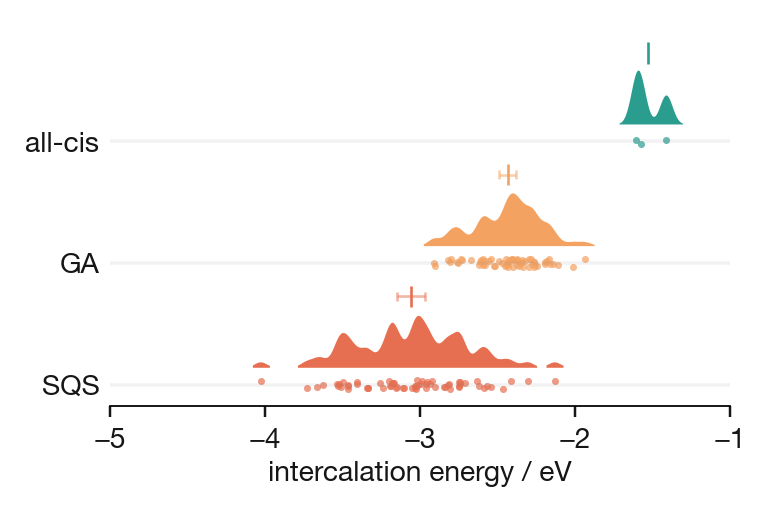

In [6]:
axes = plt.subplot(111)
kde_vscale = 0.01
baseline_offset = 0.35
kde_threshold = 0.05
e_range = np.linspace(-5.0, 0, 500)
bandwidth = 0.04

pcolors = {0: colors['dark orange'],
           1: colors['light orange'],
           2: colors['green']}

v_scale = {0: 0.9,
           1: 0.6,
           2: 4.8}

for n, data in enumerate([sqs_energy, ga_energy, cis_energy]):
    axes.plot(data, np.full_like(data, n)*2 + np.random.random(size=len(data))*0.15,
             'o',
             color=pcolors[n],
             markersize=2,
             alpha=0.7, markeredgecolor=None, markeredgewidth=0.0)
    kde = gaussian_kde(dataset=data,
                       bw_method=bandwidth / data.std(ddof=1))
    baseline = n*2 + baseline_offset
    x_loc = np.where(kde(e_range) > 0)
    axes.fill_between(e_range, kde(e_range)*kde_vscale*data.size*v_scale[n] + baseline, baseline,
                     color=pcolors[n],
                     where=kde(e_range)>kde_threshold, interpolate=False, linewidth=0.5, alpha=1, edgecolor=None)

# plot mean values
y_error_pos = []
plt.vlines(np.mean(cis_energy), 5.35, 5.7, color=pcolors[2], linewidth=0.75)
plt.vlines(np.mean(ga_energy), 3.35, 3.7, color=pcolors[1], linewidth=0.75)
plt.vlines(np.mean(sqs_energy), 1.35, 1.7, color=pcolors[0], linewidth=0.75)
# plot GA 95% confidence interval for mean using Bayesian bootstrap
bb_ga = bayesian_bootstrap(data=ga_energy, n_samples=100000)
plt.hlines(3.525, *np.percentile(bb_ga, [2.5, 97.5]), color=pcolors[1], linewidth=0.75, alpha=0.5)
plt.vlines(np.percentile(bb_ga, [2.5, 97.5]), 3.45, 3.6, color=pcolors[1], linewidth=0.75, alpha=0.5)
bb_sqs = bayesian_bootstrap(data=sqs_energy, n_samples=100000)
plt.hlines(1.525, *np.percentile(bb_sqs, [2.5, 97.5]), color=pcolors[0], linewidth=0.75, alpha=0.5) 
plt.vlines(np.percentile(bb_sqs, [2.5, 97.5]), 1.45, 1.6, color=pcolors[0], linewidth=0.75, alpha=0.5)
# plt.ylim([-1,7])
axes.set_yticks([0.075, 2.075, 4.075])
axes.set_yticklabels(['SQS','GA','all-cis'])
# plt.ylabel('n(O–Ti–O)')
plt.xlabel('intercalation energy / eV')
axes.spines[['right', 'top', 'left']].set_visible(False)
plt.hlines([0.075, 2.075, 4.075], -5.0, -1.0, color='grey', alpha=0.1)
plt.xlim([-5, -1])
axes.tick_params(axis='y', which='both',length=0)
plt.savefig('Li_intercalation.pdf', dpi=300)
plt.show()

In [7]:
print(np.mean(cis_energy), np.mean(ga_energy), np.mean(sqs_energy))

-1.530233173333358 -2.435142047419457 -3.056789724531205


In [10]:
np.percentile(bb_ga, [2.5, 97.5])-np.mean(ga_energy)

array([-0.05324361,  0.05148083])

In [11]:
np.percentile(bb_sqs, [2.5, 97.5])-np.mean(bb_sqs)

array([-0.08941694,  0.08928822])